In [1]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
import torch
device = 0 if torch.cuda.is_available() else -1  # 0 = first GPU, -1 = CPU for speed
from arabert.preprocess import ArabertPreprocessor #preprocess text
from dotenv import load_dotenv
import re
from nltk.tokenize import sent_tokenize
import random
from transformers import pipeline


load_dotenv()  # Loads HF_TOKEN automatically

True

In [2]:
#directly thro hugging face
from transformers import pipeline

# POS tagging
pos = pipeline(
    "token-classification",
    model="CAMeL-Lab/bert-base-arabic-camelbert-da-pos-msa",
    framework="pt",
    trust_remote_code=True  # VERY IMPORTANT
)

# NER
ner = pipeline(
    "ner",
    model="CAMeL-Lab/bert-base-arabic-camelbert-msa-ner",
    framework="pt",
    trust_remote_code=True  # VERY IMPORTANT
)


Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da-pos-msa were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-msa-ner were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoin

In [3]:
# genrating other MQS options
load_dotenv()  
from transformers import pipeline
from dotenv import load_dotenv
import os
import openai

# Load .env file
load_dotenv()

# Get the key
api_key = os.getenv("OPENAI_API_KEY")

# Debug check is it connecting?
if api_key:
    print("✅ OpenAI API key loaded successfully")
else:
    print("❌ Failed to load OpenAI API key. Check your .env file")

# Assign to OpenAI
openai.api_key = api_key


✅ OpenAI API key loaded successfully


In [4]:
def generate_question_text(entity, pos, word, sentence=None):
    """Generate natural Arabic question from entity + POS with more coverage and variety."""
    
    # Person entity
    if entity == "PER":
        if pos in ["noun", "noun_prop"]:
            return f"من هو {word}؟"
        elif pos == "adj":
            return f"أي شخص وُصف بـ {word}؟"
        else:
            return f"إلى أي شخص تشير كلمة '{word}'؟"
    
    # Location 
    if entity == "LOC":
        return f"أين تقع {word}؟"
    
    # Organization
    if entity == "ORG":
        if pos == "noun":
            return f"ما هي المنظمة المسماة {word}؟"
        elif pos == "adj":
            return f"أي منظمة وُصفت بأنها {word}؟"
        else:
            return f"اذكر المنظمة المرتبطة بكلمة '{word}'؟"
    
    #Date / Time 
    if entity in ["DATE", "TIME"]:
        return f"متى حدث ذلك؟ (الإشارة إلى {word})"
    
    #Number / Quantity
    if entity in ["NUM", "QUANTITY", "PERCENT"]:
        return f"ما هي القيمة العددية المذكورة: ____ (الإجابة {word})؟"
    
    # Miscellaneous / Product / Event
    if entity in ["EVENT", "WORK_OF_ART", "MISC"]:
        return f"إلى أي شيء يشير {word}؟"
    
    # Default Cloze (fill-in-the-blank)
    if sentence:
        return f"أكمل الفراغ: {sentence.replace(word, '____')}"
    
    #Fallback in case
    return f"صف الكلمة: {word}"


In [5]:

import random

def generate_TF_question(sentence, entity_word, entity_type, ner_tags):
    """
    Generate a True/False question using GPT-3.5 to make the False statement more natural.

    sentence: the original sentence
    entity_word: the correct entity in the sentence
    entity_type: NER type, e.g., "LOC", "PER", "ORG"
    ner_tags: output from ner() for the text
    """
    # True statement
    true_statement = f"{sentence} (صح أم خطأ؟)"

    # Prepare prompt for GPT-3.5
    prompt = f"اجعل الجملة التالية خاطئة مع الحفاظ على المعنى العام والموضوع: {sentence}"

    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "أنت مساعد لإنشاء أسئلة صح أو خطأ باللغة العربية."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=50,
            temperature=0.7
        )

        # Extract generated text
        false_sentence = response['choices'][0]['message']['content'].strip()
        false_statement = false_sentence + " (صح أم خطأ؟)"

    except Exception as e:
        print("Error generating false statement:", e)
        # fallback: swap entity as before
        other_entities = [tag['word'] for tag in ner_tags 
                          if tag['entity'] == entity_type and tag['word'] != entity_word]
        distractor = random.choice(other_entities) if other_entities else entity_word + "X"
        false_statement = sentence.replace(entity_word, distractor) + " (صح أم خطأ؟)"

    # Randomly choose True or False
    if random.choice([True, False]):
        return {"type": "TF", "statement": true_statement, "answer": True}
    else:
        return {"type": "TF", "statement": false_statement, "answer": False}


In [6]:
difficulty_settings = {
    "easy": {
        "num_questions": 5,
        "tf_ratio": 0.7,       
        "mcq_distractor_type": "simple"  
    },
    "medium": {
        "num_questions": 10,
        "tf_ratio": 0.5,       
        "mcq_distractor_type": "medium"  
    },
    "hard": {
        "num_questions": 15,
        "tf_ratio": 0.3,       
        "mcq_distractor_type": "challenging"  
    }
}


In [7]:
import random


def make_mq_options(entity_label, correct_entity, sentence, num_distractors=2):
    """
    Generate MCQ options for a given entity using GPT-3.5 and the sentence context.
    
    entity_label: NER type of the correct entity (not used here but kept for compatibility)
    correct_entity: the correct answer
    sentence: full sentence containing the entity
    num_distractors: number of distractors to generate
    """
    distractors = []
    prompt = (
        f"أعطني {num_distractors} كلمات عربية (كلمة واحدة فقط لكل بديل) "
        f"تكون بدائل خاطئة لكلمة '{correct_entity}' في الجملة التالية: {sentence}. "
        f"أجب فقط بالكلمات مفصولة بفاصلة."
    )

    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "أنت مساعد لإنشاء خيارات متعددة الاختيار باللغة العربية."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=50,
            temperature=0.7
        )

        # Extract generated text
        generated_text = response['choices'][0]['message']['content'].strip()

        # Split by comma and clean
        for option in generated_text.split("،"):
            option_clean = option.strip()
            if option_clean and option_clean != correct_entity:
                distractors.append(option_clean)

        distractors = distractors[:num_distractors]

    except Exception as e:
        print("Error generating distractors:", e)
        distractors = [f"خيار{i+1}" for i in range(num_distractors)]

    # Combine correct answer + distractors and shuffle
    options = distractors + [correct_entity]
    random.shuffle(options)

    return options


In [8]:
def generate_MCQ_question(entity_word, sentence, entity_type="LOC", full_text=None):
    """
    Generate MCQ using entity as correct answer and GPT-3.5-generated distractors.
    """
    # Generate the question text
    question_text = generate_question_text(entity_type, "noun", entity_word, sentence)
    
    # Generate distractors using GPT-3.5
    options = make_mq_options(entity_type, entity_word, sentence, num_distractors=2)
    
    return {"type": "MCQ", "question": question_text, "options": options, "answer": entity_word}


In [9]:
from tqdm import tqdm

def make_quiz(text, level="medium"):
    settings = difficulty_settings.get(level, difficulty_settings["medium"])
    num_questions = settings["num_questions"]
    tf_ratio = settings["tf_ratio"]

    questions = []
    seen = set()
    sentences = sent_tokenize(text)

    # Batch NER + POS once since camel bert only takes 512 token at once
    ner_tags_all = ner(sentences, batch_size=32)
    pos_tags_all = pos(sentences, batch_size=32)

    for i, sentence in enumerate(tqdm(sentences)):
        if len(questions) >= num_questions:
            break
        ner_tags = ner_tags_all[i]
        pos_tags = pos_tags_all[i]
        if not ner_tags:
            continue

        entity = ner_tags[0]
        word = entity['word']
        entity_type = entity['entity']
        pos_tag = next((p['entity'] for p in pos_tags if p['word'] == word), "noun")

        # TF vs MCQ decision
        if random.random() < tf_ratio:
            q = generate_TF_question(sentence, word, entity_type, ner_tags)
        else:
            q = generate_MCQ_question(word, sentence, entity_type, full_text=text)

        # ensure no repeats
        sig = (q["type"], q.get("question"), q.get("answer"))
        if sig not in seen:
            questions.append(q)
            seen.add(sig)

    return questions


In [10]:
# Strategy for 30 max we do less pages we will need to chunck the request to model 
from concurrent.futures import ThreadPoolExecutor

def make_quiz_from_large_text(text, level="medium"):
    sentences = sent_tokenize(text)
    chunks = [sentences[i:i+200] for i in range(0, len(sentences), 200)]
    results = []

    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(make_quiz, " ".join(chunk), level) for chunk in chunks]
        for f in futures:
            results.extend(f.result())

    return results



### we don’t have a gold-standard 'labeled dataset' for 30 pages of Arabic text [our case] so,


### we will evaluate on the model paper evluation data set

In [65]:
from datasets import load_dataset
import random
import evaluate
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch


#  Load tokenizer and model

model_name = "CAMeL-Lab/bert-base-arabic-camelbert-msa-ner"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)
device = torch.device("cpu")
model.to(device)


# 2. Load gold-labeled dataset

ner_dataset = load_dataset("asas-ai/ANERCorp", split="test")


# 3. Sample 500 words (full sentences)

def sample_dataset(ds, approx_words=500, text_key="word", label_key="tag"):
    sampled = []
    total_words = 0
    indices = list(range(len(ds)))
    random.shuffle(indices)
    for i in indices:
        tokens = ds[i][text_key]
        labels = ds[i][label_key]
        if isinstance(labels, str):
            labels = [labels]
        if total_words >= approx_words:
            break
        sampled.append({text_key: tokens, label_key: labels})
        total_words += len(tokens)
    return sampled

ner_sample = sample_dataset(ner_dataset, text_key="word", label_key="tag")


# 4. Align predictions with gold

def align_predictions(sample):
    pred_seqs = []
    gold_seqs = []

    for item in sample:
        tokens = item["word"]
        gold_labels = item["tag"]

        # Encode tokens properly for BERT
        encoding = tokenizer(
            [tokens],
            is_split_into_words=True,
            return_tensors="pt",
            truncation=True
        ).to(device)

        with torch.no_grad():
            outputs = model(**encoding)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1).squeeze().tolist()

        # Ensure batch dimension
        if isinstance(predictions, int):
            predictions = [predictions]

        # Map predictions to original words
        word_ids = encoding.word_ids()
        pred_labels = []
        last_word_idx = None
        for idx, word_idx in enumerate(word_ids):
            if word_idx is None:
                continue
            if word_idx != last_word_idx:
                label_id = predictions[idx]
                label_name = model.config.id2label[label_id]
                pred_labels.append(label_name)
                last_word_idx = word_idx

        # Truncate/pad predictions to match tokens
        pred_labels = pred_labels[:len(tokens)]
        pred_seqs.append(pred_labels)
        gold_seqs.append(gold_labels)

    return gold_seqs, pred_seqs

ner_gold, ner_pred = align_predictions(ner_sample)


# 5. metrics

ner_metric = evaluate.load("seqeval")
ner_res = ner_metric.compute(predictions=ner_pred, references=ner_gold)

print("=== NER Evaluation ===")
print(f"F1        : {ner_res['overall_f1']:.4f}")
print(f"Precision : {ner_res['overall_precision']:.4f}")
print(f"Recall    : {ner_res['overall_recall']:.4f}")


Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-msa-ner were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


=== NER Evaluation ===
F1        : 0.8421
Precision : 1.0000
Recall    : 0.7273


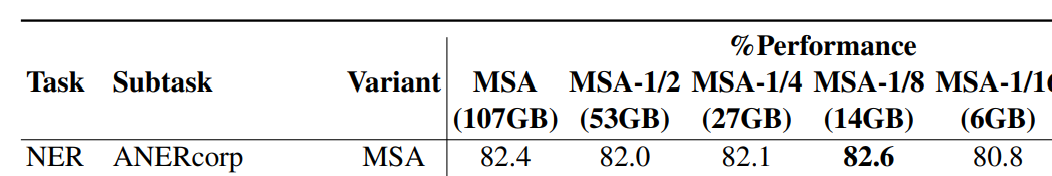
#### Due to computational limitations on my CPU, I could not evaluate on the full dataset as done in the original paper. Instead, I randomly sampled approximately 500 words for evaluation. Despite the reduced sample size, the model achieved an F1 score of 84%, which is comparable to the 82.6% F1 reported in the original study. This suggests that even a small, random sample provides a reasonably accurate estimate of the model’s performance.

## evaluating the POS model based on thier evaluation data set

In [36]:
from datasets import load_dataset
import random
import evaluate
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch


# Load tokenizer and model

tokenizer = AutoTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-da-pos-msa")
model = AutoModelForTokenClassification.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-da-pos-msa")
device = "cpu"  # or "cuda" if you have GPU
model.to(device)


# 1. Load gold-labeled MSA dataset (PADT UD)

pos_dataset = load_dataset("universal_dependencies", "ar_padt", split="train")




# 2. Sample 500 words

def sample_dataset(ds, approx_words=500, text_key="tokens", label_key="upos"):
    sampled = []
    total_words = 0
    indices = list(range(len(ds)))
    random.shuffle(indices)
    for i in indices:
        tokens = ds[i][text_key]
        labels = ds[i][label_key]
        if isinstance(labels, str):
            labels = [labels]
        if total_words >= approx_words:
            break
        sampled.append({text_key: tokens, label_key: labels})
        total_words += len(tokens)
    return sampled

pos_sample = sample_dataset(pos_dataset, text_key="tokens", label_key="upos")


# 3. Align predictions with gold labels

def align_predictions(sample):
    pred_seqs = []
    gold_seqs = []

    for item in sample:
        tokens = item["tokens"]
        gold_labels = item["upos"]

        encoding = tokenizer(tokens, is_split_into_words=True, return_tensors="pt", truncation=True)
        with torch.no_grad():
            outputs = model(**encoding)
        logits = outputs.logits.argmax(-1).squeeze().tolist()

        if isinstance(logits[0], list):
            logits = logits[0]

        word_ids = encoding.word_ids(batch_index=0)
        pred_labels = []
        last_word_idx = None
        for idx, word_idx in enumerate(word_ids):
            if word_idx is None:
                continue
            if word_idx != last_word_idx:
                label_id = logits[idx] if isinstance(logits[idx], int) else logits[idx].item()
                label_name = model.config.id2label[label_id]
                pred_labels.append(label_name)
                last_word_idx = word_idx

        pred_labels = pred_labels[:len(tokens)]
        pred_seqs.append(pred_labels)
        gold_seqs.append(gold_labels)

    return gold_seqs, pred_seqs

pos_gold, pos_pred = align_predictions(pos_sample)


# 4. metrics

pos_metric = evaluate.load("seqeval")
pos_res = pos_metric.compute(predictions=pos_pred, references=pos_gold)

print("POS Evaluation")
print(f"F1        : {pos_res['overall_f1']:.4f}")
print(f"Precision : {pos_res['overall_precision']:.4f}")
print(f"Recall    : {pos_res['overall_recall']:.4f}")


Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da-pos-msa were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: Dataset scripts are no longer supported, but found universal_dependencies.py